# Two level recommendation system


In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for matrix
from scipy.sparse import csr_matrix

# matrix factorization
from implicit import als

# Second level model
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# my own function
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items_0
from src.recommenders import MainRecommender

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def popular_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [3]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing

data = data[data['item_id'] != 999999] #droped all popular items which we marked as 999999
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
#decrease our set to 5000 most popular items to provide better speed
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items_0(data_train_lvl_1) 
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [5]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
#drop those users who are absent in train dataset and vice versa
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1['user_id'].isin(data_train_lvl_1['user_id'])]
data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1['user_id'].isin(data_val_lvl_1['user_id'])]

In [7]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


Trying to offer similar items to user using different approaches. <br>
Check the quality on the data_val_lvl_1 dataset. It's next 6 weeks after the train.

In [8]:
N = 5

In [9]:
recommender.get_als_recommendations(2375, N=N)

[899624, 904360, 981760, 923746, 1082185]

In [10]:
recommender.get_own_recommendations(2375, N=N)

[1036501, 1079023, 1085983, 907099, 910439]

In [11]:
recommender.get_similar_items_recommendation(2375, N=N)

[1073150, 889731, 1055646, 1046545, 981760]

In [12]:
recommender.get_similar_users_recommendation(2375, N=N)

[834103, 888650, 1082990, 1065538, 1124971]

In [13]:
popular_recommendation(data_train_lvl_1, n=N)

[999999, 6534178, 6533889, 1029743, 6534166]

In [14]:
result_lvl_1

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
...,...,...
2148,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16..."
2149,2497,"[820291, 824759, 838797, 859010, 859075, 86077..."
2150,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15..."
2151,2499,"[861282, 921744, 1050968, 13842089, 828837, 86..."


Finally make first level predictions for our users

In [15]:
N = 500

In [16]:
popular_recs = popular_recommendation(data_train_lvl_1, n=N)

In [17]:
result_lvl_2 = result_lvl_1.copy()

In [18]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))
result_lvl_1['popular_recommendation'] = result_lvl_1['user_id'].apply(lambda x: popular_recs)
#result_lvl_1['similar_user'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N))

In [19]:
result_lvl_1.head()

,user_id,actual,als,own_recommendations,similar_items,popular_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1082212, 1094924, 1047619, 1004390, 956609, 1...","[856942, 9297615, 5577022, 1074612, 9655212, 9...","[824758, 999999, 1082185, 864774, 1124432, 940...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1041259, 854852, 908846, 951412, 847...","[1076580, 911974, 826784, 1083296, 838136, 820...","[8090509, 1133018, 7025275, 1106523, 985999, 8...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[891423, 902172, 846550, 1036347, 1058930, 111...","[891423, 910109, 887003, 1121367, 951821, 1115...","[951590, 843450, 1074754, 862732, 1139525, 880...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1082185, 878996, 1024306, 965267, 857006, 102...","[13003092, 1119051, 9911484, 8203834, 1108094,...","[999999, 904360, 874149, 845208, 948650, 70252...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1003188, 853643, 938187, 892004, 849843, 1060...","[845814, 1075524, 1097544, 1112957, 9338009, 6...","[999999, 1038985, 1015247, 922307, 836793, 113...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."


In [20]:
ac, own = result_lvl_1.iloc[0]['actual'], result_lvl_1.iloc[0]['own_recommendations']

In [21]:
result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()

0.028254776126099175

In [22]:
result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual']), axis=1).mean()

0.015398197524880447

In [23]:
result_lvl_1.apply(lambda row: recall_at_k(row['similar_items'], row['actual']), axis=1).mean()

0.01128091886229823

In [24]:
result_lvl_1.apply(lambda row: recall_at_k(row['popular_recommendation'], row['actual']), axis=1).mean()

0.014669071440125525

In [25]:
#result_lvl_1.apply(lambda row: recall_at_k(row['similar_user'], row['actual']), axis=1).mean()

Лучшие recall показываают own recommendtions + top-popular лучший

In [26]:
k_list = [5, 10, 20, 50, 100, 200, 500]
score = []
for k in k_list:
    score.append(result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], k=k), axis=1).mean())

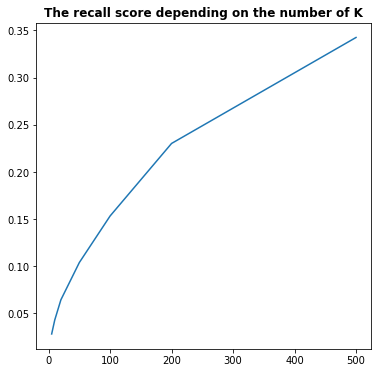

In [27]:
plt.figure(figsize=(6,6))
plt.plot(k_list, score)
plt.title("The recall score depending on the number of K", fontweight = 'bold')
plt.show()

The more items we take on the first level predictions the better chance that we will make a better prediction on the second final level

Обучаем модель 2-ого уровня, при этом надо добавить минимум по 2 фичи для юзера, товара и пары юзер-товар

In [28]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

N = 200
users_lvl_2['own_recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
users_lvl_2['als'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))
users_lvl_2['similar_items'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))
users_lvl_2['popular_recommendation'] = users_lvl_2['user_id'].apply(lambda x: popular_recs)

In [29]:
users_lvl_2.head(2)

,user_id,own_recommendations,als,similar_items,popular_recommendation
0,2070,"[834103, 878302, 1119399, 1085604, 13511722, 9...","[1082185, 908531, 981760, 1029743, 1080414, 87...","[1037894, 879755, 949616, 879948, 9526563, 106...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."
1,2021,"[1119454, 1019142, 871279, 835578, 863762, 101...","[896938, 951590, 1037863, 871756, 895930, 8468...","[960318, 883932, 904360, 819255, 12301109, 111...","[999999, 6534178, 6533889, 1029743, 6534166, 1..."


In [30]:
users_lvl_2['candidates'] = users_lvl_2['own_recommendations'] + users_lvl_2['als'] + users_lvl_2['similar_items'] + users_lvl_2['popular_recommendation']
users_lvl_2 = users_lvl_2[['user_id','candidates' ]]

In [31]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[834103, 878302, 1119399, 1085604, 13511722, 9..."
1,2021,"[1119454, 1019142, 871279, 835578, 863762, 101..."


In [32]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,834103,1
0,2070,878302,1
0,2070,1119399,1
0,2070,1085604,1


In [33]:
users_lvl_2.shape[0]

2368300

In [34]:
users_lvl_2['user_id'].nunique()

2153

In [35]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace = True)
targets_lvl_2.drop('flag', axis=1, inplace = True)

In [36]:
targets_lvl_2_val = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2_val['target'] = 1  # тут только покупки 

targets_lvl_2_val = users_lvl_2.merge(targets_lvl_2_val, on=['user_id', 'item_id'], how='left')

targets_lvl_2_val['target'].fillna(0, inplace = True)
targets_lvl_2_val.drop('flag', axis=1, inplace = True)

In [37]:
targets_lvl_2_val.head(2)

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0


(!) For every user there are N={} item_id's candidates

In [38]:
targets_lvl_2['target'].mean()

0.06060933941246653

In [39]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [40]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [41]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [42]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_features, on='item_id', how='left')
targets_lvl_2_val = targets_lvl_2_val.merge(user_features, on='user_id', how='left')

**Feature enginering**

Доп варианты, которые можно добавить:<br>
Фичи user_id:

- Средняя сумма покупки 1 товара в каждой категории
- Кол-во покупок в каждой категории
- Долю покупок в выходные
- Долю покупок утром/днем/вечером

Фичи item_id:

- Кол-во покупок в неделю
- Среднее ол-во покупок 1 товара в категории в неделю
- (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)

Фичи пары user_id - item_id

- (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
- (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
- (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [43]:
#Средний чек
average_basket = data_train_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket = average_basket.groupby('user_id')['average_basket_price'].mean().reset_index()

In [44]:
targets_lvl_2 = targets_lvl_2.merge(average_basket, on='user_id', how='left')

In [45]:
#Средний чек
average_basket_val = data_val_lvl_2.groupby(['user_id','basket_id'])['sales_value'].mean().reset_index()
average_basket_val.columns = ['user_id', 'basket_id', 'average_basket_price']
average_basket_val = average_basket_val.groupby('user_id')['average_basket_price'].mean().reset_index()

In [46]:
targets_lvl_2_val = targets_lvl_2_val.merge(average_basket_val, on='user_id', how='left')

In [47]:
#Частотность покупок раз/месяц
frequency = data_train_lvl_2.copy()
frequency['activity_per_month'] = frequency['day']%30
frequency.drop_duplicates(subset = "basket_id", keep = False, inplace = True) 
frequency = frequency.groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency = frequency.groupby('user_id')['basket_id'].mean().reset_index()
frequency.columns = ['user_id', 'purchases_per_month']
frequency.head(2)

,user_id,purchases_per_month
0,1,1.0
1,2,1.0


In [48]:
targets_lvl_2 = targets_lvl_2.merge(frequency, on='user_id', how='left')

In [49]:
#Частотность покупок раз/месяц
frequency_val = data_val_lvl_2.copy()
frequency_val ['activity_per_month'] = frequency_val['day']%30
frequency_val.drop_duplicates(subset = "basket_id", keep = False, inplace = True) 
frequency_val = frequency_val.groupby(['user_id', 'activity_per_month'])['basket_id'].count().reset_index()
frequency_val = frequency_val.groupby('user_id')['basket_id'].mean().reset_index()
frequency_val.columns = ['user_id', 'purchases_per_month']
frequency_val.head(2)

,user_id,purchases_per_month
0,1,1.0
1,6,1.0


In [50]:
targets_lvl_2_val = targets_lvl_2_val.merge(frequency, on='user_id', how='left')

In [51]:
#Кол-во покупок товара в неделю
item_per_week = data_train_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week = item_per_week.groupby('item_id')['quantity'].mean().reset_index()
item_per_week.columns = ['item_id', 'item_per_week']

In [52]:
targets_lvl_2 = targets_lvl_2.merge(item_per_week, on='item_id', how='left')

In [53]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_basket_price,purchases_per_month,item_per_week
0,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,10.166667
1,2070,834103,1.0,2224.0,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.18786,1.416667,10.166667


In [54]:
#Кол-во покупок товара в неделю
item_per_week_val = data_val_lvl_2.groupby(['item_id','week_no'])['quantity'].sum().reset_index()
item_per_week_val = item_per_week_val.groupby('item_id')['quantity'].mean().reset_index()
item_per_week_val.columns = ['item_id', 'item_per_week']

In [55]:
targets_lvl_2_val = targets_lvl_2_val.merge(item_per_week_val, on='item_id', how='left')

**Split into X & Y**

In [56]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [57]:
X_val = targets_lvl_2_val.drop('target', axis=1)
y_val = targets_lvl_2_val[['target']]

**Transform categorical features**

In [58]:
cat_feats = X_train.select_dtypes(['object']).columns.tolist()
#fillna in categorical features
#X_train[cat_feats]=X_train[cat_feats].fillna(X_train.mode().iloc[0])
X_train[cat_feats] = X_train[cat_feats].fillna('unknown') 
X_train[cat_feats] = X_train[cat_feats].astype('category')

X_train['manufacturer'].fillna(X_train['manufacturer'].mode()[0], inplace=True)
X_train['manufacturer'] = X_train['manufacturer'].astype('int').astype('category')

In [59]:
#fillna in categorical features
#X_val[cat_feats]=X_val[cat_feats].fillna(X_val.mode().iloc[0])
X_val[cat_feats] = X_val[cat_feats].fillna('unknown') 
X_val[cat_feats] = X_val[cat_feats].astype('category')

X_val['manufacturer'].fillna(X_val['manufacturer'].mode()[0], inplace=True)
X_val['manufacturer'] = X_val['manufacturer'].astype('int').astype('category')

cat_feats.append('manufacturer')
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer']

In [60]:
#drop columns item_id, user_id because they don't provide any information
X_train_ = X_train.drop(columns=['item_id', 'user_id'])
X_val_ = X_val.drop(columns=['item_id', 'user_id'])

In [61]:
y_train.mean()

target    0.060609
dtype: float64

**LightGBM**

In [62]:
lgb_params = { 
    'objective':'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 3000,
    'learning_rate': 0.15,
    'max_depth': 4,
    'categorical_column': cat_feats,
    'random_state': 27,
    'verbose': 1,
    'is_unbalance': True
}
#'reg_alpha': 0.436193,
#'reg_lambda': 0.479169,
# 
#'subsample_for_bin': 240000,

In [63]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X=X_train_,
        y=y_train,
        eval_set=[(X_train_, y_train)],
        early_stopping_rounds=500,
        eval_metric=['binary_error'],
        verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:814: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's binary_error: 0.0606093	training's binary_logloss: 0.253765
Training until validation scores don't improve for 500 rounds
[2]	training's binary_error: 0.0606093	training's binary_logloss: 0.287899
[3]	training's binary_error: 0.0644088	training's binary_logloss: 0.320084
[4]	training's binary_error: 0.0743081	training's binary_logloss: 0.350004
[5]	training's binary_error: 0.0968972	training's binary_logloss: 0.376892
[6]	training's binary_error: 0.11729	training's binary_logloss: 0.400825
[7]	training's binary_error: 0.127951	training's binary_logloss: 0.422158
[8]	training's binary_error: 0.135237	training's binary_logloss: 0.441036
[9]	training's binary_error: 0.142881	training's binary_logloss: 0.457727
[10]	training's binary_error: 0.150196	training's binary_logloss: 0.472339
[11]	training's binary_error: 0.171752	training's binary_logloss: 0.48533
[12]	training's binary_error: 0.186892	training's binary_logloss: 0.496329
[13]	training's binary_error: 0.198162	train

[110]	training's binary_error: 0.272542	training's binary_logloss: 0.530761
[111]	training's binary_error: 0.272491	training's binary_logloss: 0.530678
[112]	training's binary_error: 0.272039	training's binary_logloss: 0.530237
[113]	training's binary_error: 0.271609	training's binary_logloss: 0.529762
[114]	training's binary_error: 0.271444	training's binary_logloss: 0.529574
[115]	training's binary_error: 0.270975	training's binary_logloss: 0.529261
[116]	training's binary_error: 0.270736	training's binary_logloss: 0.528911
[117]	training's binary_error: 0.270727	training's binary_logloss: 0.528738
[118]	training's binary_error: 0.270519	training's binary_logloss: 0.528487
[119]	training's binary_error: 0.27056	training's binary_logloss: 0.528397
[120]	training's binary_error: 0.270521	training's binary_logloss: 0.52828
[121]	training's binary_error: 0.270357	training's binary_logloss: 0.528132
[122]	training's binary_error: 0.270381	training's binary_logloss: 0.527655
[123]	training

[219]	training's binary_error: 0.255834	training's binary_logloss: 0.508132
[220]	training's binary_error: 0.255795	training's binary_logloss: 0.508023
[221]	training's binary_error: 0.255522	training's binary_logloss: 0.507763
[222]	training's binary_error: 0.25545	training's binary_logloss: 0.507669
[223]	training's binary_error: 0.255278	training's binary_logloss: 0.507521
[224]	training's binary_error: 0.255141	training's binary_logloss: 0.507416
[225]	training's binary_error: 0.255017	training's binary_logloss: 0.507213
[226]	training's binary_error: 0.254861	training's binary_logloss: 0.506951
[227]	training's binary_error: 0.254751	training's binary_logloss: 0.506849
[228]	training's binary_error: 0.254676	training's binary_logloss: 0.506745
[229]	training's binary_error: 0.254628	training's binary_logloss: 0.506686
[230]	training's binary_error: 0.254198	training's binary_logloss: 0.506108
[231]	training's binary_error: 0.253906	training's binary_logloss: 0.505807
[232]	trainin

[329]	training's binary_error: 0.244662	training's binary_logloss: 0.492245
[330]	training's binary_error: 0.244479	training's binary_logloss: 0.492063
[331]	training's binary_error: 0.24405	training's binary_logloss: 0.491718
[332]	training's binary_error: 0.244126	training's binary_logloss: 0.491658
[333]	training's binary_error: 0.243892	training's binary_logloss: 0.491413
[334]	training's binary_error: 0.243789	training's binary_logloss: 0.491355
[335]	training's binary_error: 0.2438	training's binary_logloss: 0.491281
[336]	training's binary_error: 0.243577	training's binary_logloss: 0.49111
[337]	training's binary_error: 0.243505	training's binary_logloss: 0.491069
[338]	training's binary_error: 0.243452	training's binary_logloss: 0.490941
[339]	training's binary_error: 0.243404	training's binary_logloss: 0.490885
[340]	training's binary_error: 0.243312	training's binary_logloss: 0.490843
[341]	training's binary_error: 0.243241	training's binary_logloss: 0.49075
[342]	training's 

[438]	training's binary_error: 0.235383	training's binary_logloss: 0.479826
[439]	training's binary_error: 0.23527	training's binary_logloss: 0.479678
[440]	training's binary_error: 0.235159	training's binary_logloss: 0.479553
[441]	training's binary_error: 0.235031	training's binary_logloss: 0.479405
[442]	training's binary_error: 0.234991	training's binary_logloss: 0.479312
[443]	training's binary_error: 0.234852	training's binary_logloss: 0.479158
[444]	training's binary_error: 0.234672	training's binary_logloss: 0.479049
[445]	training's binary_error: 0.234665	training's binary_logloss: 0.479003
[446]	training's binary_error: 0.234631	training's binary_logloss: 0.478952
[447]	training's binary_error: 0.234581	training's binary_logloss: 0.478848
[448]	training's binary_error: 0.234509	training's binary_logloss: 0.478792
[449]	training's binary_error: 0.234448	training's binary_logloss: 0.478732
[450]	training's binary_error: 0.234373	training's binary_logloss: 0.478604
[451]	trainin

[548]	training's binary_error: 0.227069	training's binary_logloss: 0.468328
[549]	training's binary_error: 0.226963	training's binary_logloss: 0.468222
[550]	training's binary_error: 0.226876	training's binary_logloss: 0.468043
[551]	training's binary_error: 0.226787	training's binary_logloss: 0.467945
[552]	training's binary_error: 0.226749	training's binary_logloss: 0.467897
[553]	training's binary_error: 0.226604	training's binary_logloss: 0.46775
[554]	training's binary_error: 0.226541	training's binary_logloss: 0.467578
[555]	training's binary_error: 0.226467	training's binary_logloss: 0.467512
[556]	training's binary_error: 0.226397	training's binary_logloss: 0.467423
[557]	training's binary_error: 0.226343	training's binary_logloss: 0.467321
[558]	training's binary_error: 0.226331	training's binary_logloss: 0.46726
[559]	training's binary_error: 0.2263	training's binary_logloss: 0.467154
[560]	training's binary_error: 0.226202	training's binary_logloss: 0.467069
[561]	training's

[658]	training's binary_error: 0.219817	training's binary_logloss: 0.458107
[659]	training's binary_error: 0.219717	training's binary_logloss: 0.457982
[660]	training's binary_error: 0.219664	training's binary_logloss: 0.457906
[661]	training's binary_error: 0.219631	training's binary_logloss: 0.457869
[662]	training's binary_error: 0.219583	training's binary_logloss: 0.457745
[663]	training's binary_error: 0.219542	training's binary_logloss: 0.457709
[664]	training's binary_error: 0.219535	training's binary_logloss: 0.457654
[665]	training's binary_error: 0.21935	training's binary_logloss: 0.457528
[666]	training's binary_error: 0.219408	training's binary_logloss: 0.45743
[667]	training's binary_error: 0.219367	training's binary_logloss: 0.457379
[668]	training's binary_error: 0.219311	training's binary_logloss: 0.457335
[669]	training's binary_error: 0.219299	training's binary_logloss: 0.457256
[670]	training's binary_error: 0.21926	training's binary_logloss: 0.457228
[671]	training'

[767]	training's binary_error: 0.214388	training's binary_logloss: 0.450365
[768]	training's binary_error: 0.214405	training's binary_logloss: 0.450335
[769]	training's binary_error: 0.214379	training's binary_logloss: 0.450271
[770]	training's binary_error: 0.214376	training's binary_logloss: 0.450238
[771]	training's binary_error: 0.214358	training's binary_logloss: 0.450183
[772]	training's binary_error: 0.214333	training's binary_logloss: 0.450123
[773]	training's binary_error: 0.214331	training's binary_logloss: 0.450096
[774]	training's binary_error: 0.214231	training's binary_logloss: 0.450021
[775]	training's binary_error: 0.214228	training's binary_logloss: 0.449925
[776]	training's binary_error: 0.214188	training's binary_logloss: 0.449883
[777]	training's binary_error: 0.21414	training's binary_logloss: 0.44973
[778]	training's binary_error: 0.214124	training's binary_logloss: 0.449674
[779]	training's binary_error: 0.214055	training's binary_logloss: 0.449597
[780]	training

[877]	training's binary_error: 0.209484	training's binary_logloss: 0.442829
[878]	training's binary_error: 0.209466	training's binary_logloss: 0.442799
[879]	training's binary_error: 0.20941	training's binary_logloss: 0.442749
[880]	training's binary_error: 0.209378	training's binary_logloss: 0.442704
[881]	training's binary_error: 0.209395	training's binary_logloss: 0.442669
[882]	training's binary_error: 0.209346	training's binary_logloss: 0.442592
[883]	training's binary_error: 0.209261	training's binary_logloss: 0.442481
[884]	training's binary_error: 0.209199	training's binary_logloss: 0.442395
[885]	training's binary_error: 0.209143	training's binary_logloss: 0.442358
[886]	training's binary_error: 0.209167	training's binary_logloss: 0.442314
[887]	training's binary_error: 0.209145	training's binary_logloss: 0.442277
[888]	training's binary_error: 0.209171	training's binary_logloss: 0.442238
[889]	training's binary_error: 0.20916	training's binary_logloss: 0.442207
[890]	training

[987]	training's binary_error: 0.205172	training's binary_logloss: 0.436391
[988]	training's binary_error: 0.205141	training's binary_logloss: 0.436371
[989]	training's binary_error: 0.205121	training's binary_logloss: 0.436346
[990]	training's binary_error: 0.205085	training's binary_logloss: 0.436297
[991]	training's binary_error: 0.205004	training's binary_logloss: 0.436222
[992]	training's binary_error: 0.204994	training's binary_logloss: 0.436177
[993]	training's binary_error: 0.204967	training's binary_logloss: 0.436104
[994]	training's binary_error: 0.204939	training's binary_logloss: 0.436081
[995]	training's binary_error: 0.204948	training's binary_logloss: 0.43605
[996]	training's binary_error: 0.204903	training's binary_logloss: 0.435991
[997]	training's binary_error: 0.204834	training's binary_logloss: 0.435935
[998]	training's binary_error: 0.204671	training's binary_logloss: 0.435792
[999]	training's binary_error: 0.204604	training's binary_logloss: 0.435696
[1000]	traini

[1094]	training's binary_error: 0.200664	training's binary_logloss: 0.429676
[1095]	training's binary_error: 0.20063	training's binary_logloss: 0.429625
[1096]	training's binary_error: 0.200612	training's binary_logloss: 0.429588
[1097]	training's binary_error: 0.200622	training's binary_logloss: 0.429544
[1098]	training's binary_error: 0.200628	training's binary_logloss: 0.42952
[1099]	training's binary_error: 0.200558	training's binary_logloss: 0.42943
[1100]	training's binary_error: 0.200569	training's binary_logloss: 0.429386
[1101]	training's binary_error: 0.200543	training's binary_logloss: 0.42934
[1102]	training's binary_error: 0.200542	training's binary_logloss: 0.429298
[1103]	training's binary_error: 0.200511	training's binary_logloss: 0.429246
[1104]	training's binary_error: 0.200443	training's binary_logloss: 0.42918
[1105]	training's binary_error: 0.200431	training's binary_logloss: 0.429135
[1106]	training's binary_error: 0.200282	training's binary_logloss: 0.429031
[110

[1201]	training's binary_error: 0.197532	training's binary_logloss: 0.424627
[1202]	training's binary_error: 0.197518	training's binary_logloss: 0.424594
[1203]	training's binary_error: 0.197496	training's binary_logloss: 0.42449
[1204]	training's binary_error: 0.197473	training's binary_logloss: 0.424462
[1205]	training's binary_error: 0.197433	training's binary_logloss: 0.424427
[1206]	training's binary_error: 0.197368	training's binary_logloss: 0.424402
[1207]	training's binary_error: 0.197365	training's binary_logloss: 0.424354
[1208]	training's binary_error: 0.197322	training's binary_logloss: 0.424334
[1209]	training's binary_error: 0.19727	training's binary_logloss: 0.424303
[1210]	training's binary_error: 0.197274	training's binary_logloss: 0.424288
[1211]	training's binary_error: 0.197189	training's binary_logloss: 0.424241
[1212]	training's binary_error: 0.197135	training's binary_logloss: 0.424085
[1213]	training's binary_error: 0.197103	training's binary_logloss: 0.423969
[

[1308]	training's binary_error: 0.194077	training's binary_logloss: 0.419423
[1309]	training's binary_error: 0.193943	training's binary_logloss: 0.419283
[1310]	training's binary_error: 0.19391	training's binary_logloss: 0.419186
[1311]	training's binary_error: 0.193897	training's binary_logloss: 0.41917
[1312]	training's binary_error: 0.193871	training's binary_logloss: 0.41914
[1313]	training's binary_error: 0.193841	training's binary_logloss: 0.419121
[1314]	training's binary_error: 0.193832	training's binary_logloss: 0.419101
[1315]	training's binary_error: 0.193829	training's binary_logloss: 0.419053
[1316]	training's binary_error: 0.193812	training's binary_logloss: 0.419012
[1317]	training's binary_error: 0.193798	training's binary_logloss: 0.418984
[1318]	training's binary_error: 0.193798	training's binary_logloss: 0.418955
[1319]	training's binary_error: 0.193767	training's binary_logloss: 0.41893
[1320]	training's binary_error: 0.193714	training's binary_logloss: 0.418893
[13

[1416]	training's binary_error: 0.190766	training's binary_logloss: 0.41424
[1417]	training's binary_error: 0.190736	training's binary_logloss: 0.4142
[1418]	training's binary_error: 0.190742	training's binary_logloss: 0.414181
[1419]	training's binary_error: 0.190738	training's binary_logloss: 0.414161
[1420]	training's binary_error: 0.190717	training's binary_logloss: 0.4141
[1421]	training's binary_error: 0.190665	training's binary_logloss: 0.413995
[1422]	training's binary_error: 0.190628	training's binary_logloss: 0.413957
[1423]	training's binary_error: 0.190614	training's binary_logloss: 0.413922
[1424]	training's binary_error: 0.190598	training's binary_logloss: 0.41389
[1425]	training's binary_error: 0.190593	training's binary_logloss: 0.413857
[1426]	training's binary_error: 0.190526	training's binary_logloss: 0.413743
[1427]	training's binary_error: 0.190506	training's binary_logloss: 0.413692
[1428]	training's binary_error: 0.190485	training's binary_logloss: 0.41363
[1429]

[1523]	training's binary_error: 0.188202	training's binary_logloss: 0.409661
[1524]	training's binary_error: 0.188194	training's binary_logloss: 0.409643
[1525]	training's binary_error: 0.188189	training's binary_logloss: 0.409626
[1526]	training's binary_error: 0.18815	training's binary_logloss: 0.409564
[1527]	training's binary_error: 0.188117	training's binary_logloss: 0.409538
[1528]	training's binary_error: 0.188107	training's binary_logloss: 0.409523
[1529]	training's binary_error: 0.188035	training's binary_logloss: 0.409429
[1530]	training's binary_error: 0.188014	training's binary_logloss: 0.40941
[1531]	training's binary_error: 0.188022	training's binary_logloss: 0.409338
[1532]	training's binary_error: 0.188003	training's binary_logloss: 0.40932
[1533]	training's binary_error: 0.187995	training's binary_logloss: 0.409276
[1534]	training's binary_error: 0.187997	training's binary_logloss: 0.409262
[1535]	training's binary_error: 0.188025	training's binary_logloss: 0.40925
[15

[1631]	training's binary_error: 0.185976	training's binary_logloss: 0.405471
[1632]	training's binary_error: 0.185976	training's binary_logloss: 0.405431
[1633]	training's binary_error: 0.185977	training's binary_logloss: 0.405402
[1634]	training's binary_error: 0.185946	training's binary_logloss: 0.405383
[1635]	training's binary_error: 0.185848	training's binary_logloss: 0.40523
[1636]	training's binary_error: 0.1858	training's binary_logloss: 0.405179
[1637]	training's binary_error: 0.185795	training's binary_logloss: 0.405166
[1638]	training's binary_error: 0.185764	training's binary_logloss: 0.405144
[1639]	training's binary_error: 0.185743	training's binary_logloss: 0.405111
[1640]	training's binary_error: 0.18572	training's binary_logloss: 0.405071
[1641]	training's binary_error: 0.185669	training's binary_logloss: 0.404981
[1642]	training's binary_error: 0.185641	training's binary_logloss: 0.404954
[1643]	training's binary_error: 0.185642	training's binary_logloss: 0.404939
[16

[1740]	training's binary_error: 0.183471	training's binary_logloss: 0.401474
[1741]	training's binary_error: 0.183456	training's binary_logloss: 0.401457
[1742]	training's binary_error: 0.183453	training's binary_logloss: 0.401438
[1743]	training's binary_error: 0.183447	training's binary_logloss: 0.401421
[1744]	training's binary_error: 0.18345	training's binary_logloss: 0.401408
[1745]	training's binary_error: 0.18344	training's binary_logloss: 0.401399
[1746]	training's binary_error: 0.183431	training's binary_logloss: 0.401382
[1747]	training's binary_error: 0.183426	training's binary_logloss: 0.401321
[1748]	training's binary_error: 0.183405	training's binary_logloss: 0.401261
[1749]	training's binary_error: 0.183356	training's binary_logloss: 0.401229
[1750]	training's binary_error: 0.183336	training's binary_logloss: 0.401196
[1751]	training's binary_error: 0.183325	training's binary_logloss: 0.40116
[1752]	training's binary_error: 0.18331	training's binary_logloss: 0.401136
[17

[1847]	training's binary_error: 0.181228	training's binary_logloss: 0.397455
[1848]	training's binary_error: 0.181237	training's binary_logloss: 0.397432
[1849]	training's binary_error: 0.181202	training's binary_logloss: 0.397369
[1850]	training's binary_error: 0.181153	training's binary_logloss: 0.397304
[1851]	training's binary_error: 0.181127	training's binary_logloss: 0.397285
[1852]	training's binary_error: 0.181115	training's binary_logloss: 0.397266
[1853]	training's binary_error: 0.18111	training's binary_logloss: 0.397252
[1854]	training's binary_error: 0.181088	training's binary_logloss: 0.397238
[1855]	training's binary_error: 0.181008	training's binary_logloss: 0.39717
[1856]	training's binary_error: 0.180996	training's binary_logloss: 0.397151
[1857]	training's binary_error: 0.180955	training's binary_logloss: 0.397103
[1858]	training's binary_error: 0.180909	training's binary_logloss: 0.396979
[1859]	training's binary_error: 0.180918	training's binary_logloss: 0.396949
[

[1954]	training's binary_error: 0.179286	training's binary_logloss: 0.393601
[1955]	training's binary_error: 0.179259	training's binary_logloss: 0.393544
[1956]	training's binary_error: 0.179227	training's binary_logloss: 0.393505
[1957]	training's binary_error: 0.179204	training's binary_logloss: 0.393491
[1958]	training's binary_error: 0.179203	training's binary_logloss: 0.39346
[1959]	training's binary_error: 0.179189	training's binary_logloss: 0.393437
[1960]	training's binary_error: 0.179152	training's binary_logloss: 0.393377
[1961]	training's binary_error: 0.179143	training's binary_logloss: 0.393357
[1962]	training's binary_error: 0.179144	training's binary_logloss: 0.39334
[1963]	training's binary_error: 0.179111	training's binary_logloss: 0.393292
[1964]	training's binary_error: 0.179108	training's binary_logloss: 0.393264
[1965]	training's binary_error: 0.179084	training's binary_logloss: 0.393224
[1966]	training's binary_error: 0.179074	training's binary_logloss: 0.39321
[1

[2062]	training's binary_error: 0.176897	training's binary_logloss: 0.389459
[2063]	training's binary_error: 0.176863	training's binary_logloss: 0.389374
[2064]	training's binary_error: 0.176838	training's binary_logloss: 0.389348
[2065]	training's binary_error: 0.176841	training's binary_logloss: 0.389332
[2066]	training's binary_error: 0.176841	training's binary_logloss: 0.389317
[2067]	training's binary_error: 0.176847	training's binary_logloss: 0.389298
[2068]	training's binary_error: 0.176856	training's binary_logloss: 0.389288
[2069]	training's binary_error: 0.176848	training's binary_logloss: 0.389276
[2070]	training's binary_error: 0.176806	training's binary_logloss: 0.389233
[2071]	training's binary_error: 0.17677	training's binary_logloss: 0.389159
[2072]	training's binary_error: 0.176766	training's binary_logloss: 0.389145
[2073]	training's binary_error: 0.176734	training's binary_logloss: 0.389135
[2074]	training's binary_error: 0.17671	training's binary_logloss: 0.38909
[2

[2170]	training's binary_error: 0.17472	training's binary_logloss: 0.385989
[2171]	training's binary_error: 0.174732	training's binary_logloss: 0.385964
[2172]	training's binary_error: 0.174718	training's binary_logloss: 0.385932
[2173]	training's binary_error: 0.174708	training's binary_logloss: 0.385876
[2174]	training's binary_error: 0.174683	training's binary_logloss: 0.385867
[2175]	training's binary_error: 0.17463	training's binary_logloss: 0.385832
[2176]	training's binary_error: 0.174635	training's binary_logloss: 0.385819
[2177]	training's binary_error: 0.17464	training's binary_logloss: 0.385794
[2178]	training's binary_error: 0.174647	training's binary_logloss: 0.385774
[2179]	training's binary_error: 0.17459	training's binary_logloss: 0.385703
[2180]	training's binary_error: 0.174571	training's binary_logloss: 0.38569
[2181]	training's binary_error: 0.174569	training's binary_logloss: 0.385647
[2182]	training's binary_error: 0.174537	training's binary_logloss: 0.385628
[218

[2277]	training's binary_error: 0.173155	training's binary_logloss: 0.383071
[2278]	training's binary_error: 0.173116	training's binary_logloss: 0.383008
[2279]	training's binary_error: 0.173102	training's binary_logloss: 0.382971
[2280]	training's binary_error: 0.173024	training's binary_logloss: 0.382892
[2281]	training's binary_error: 0.173017	training's binary_logloss: 0.382861
[2282]	training's binary_error: 0.173014	training's binary_logloss: 0.38285
[2283]	training's binary_error: 0.172983	training's binary_logloss: 0.382818
[2284]	training's binary_error: 0.172927	training's binary_logloss: 0.382744
[2285]	training's binary_error: 0.172934	training's binary_logloss: 0.382725
[2286]	training's binary_error: 0.172893	training's binary_logloss: 0.382651
[2287]	training's binary_error: 0.172865	training's binary_logloss: 0.382606
[2288]	training's binary_error: 0.172816	training's binary_logloss: 0.382537
[2289]	training's binary_error: 0.172799	training's binary_logloss: 0.382501


[2385]	training's binary_error: 0.171715	training's binary_logloss: 0.380195
[2386]	training's binary_error: 0.171699	training's binary_logloss: 0.380163
[2387]	training's binary_error: 0.171678	training's binary_logloss: 0.380126
[2388]	training's binary_error: 0.171648	training's binary_logloss: 0.380091
[2389]	training's binary_error: 0.171643	training's binary_logloss: 0.380074
[2390]	training's binary_error: 0.171607	training's binary_logloss: 0.380053
[2391]	training's binary_error: 0.171609	training's binary_logloss: 0.380038
[2392]	training's binary_error: 0.171583	training's binary_logloss: 0.38002
[2393]	training's binary_error: 0.171601	training's binary_logloss: 0.379983
[2394]	training's binary_error: 0.171595	training's binary_logloss: 0.37996
[2395]	training's binary_error: 0.171562	training's binary_logloss: 0.379933
[2396]	training's binary_error: 0.171563	training's binary_logloss: 0.379904
[2397]	training's binary_error: 0.171564	training's binary_logloss: 0.379885
[

[2492]	training's binary_error: 0.170043	training's binary_logloss: 0.377152
[2493]	training's binary_error: 0.170035	training's binary_logloss: 0.37714
[2494]	training's binary_error: 0.170004	training's binary_logloss: 0.377114
[2495]	training's binary_error: 0.169996	training's binary_logloss: 0.377108
[2496]	training's binary_error: 0.169989	training's binary_logloss: 0.377094
[2497]	training's binary_error: 0.169983	training's binary_logloss: 0.37707
[2498]	training's binary_error: 0.169973	training's binary_logloss: 0.377064
[2499]	training's binary_error: 0.169957	training's binary_logloss: 0.377053
[2500]	training's binary_error: 0.169934	training's binary_logloss: 0.37704
[2501]	training's binary_error: 0.1699	training's binary_logloss: 0.377
[2502]	training's binary_error: 0.16989	training's binary_logloss: 0.376988
[2503]	training's binary_error: 0.169809	training's binary_logloss: 0.37688
[2504]	training's binary_error: 0.169795	training's binary_logloss: 0.376833
[2505]	tr

[2600]	training's binary_error: 0.168394	training's binary_logloss: 0.374301
[2601]	training's binary_error: 0.168378	training's binary_logloss: 0.374284
[2602]	training's binary_error: 0.168372	training's binary_logloss: 0.374271
[2603]	training's binary_error: 0.168376	training's binary_logloss: 0.374257
[2604]	training's binary_error: 0.16828	training's binary_logloss: 0.374151
[2605]	training's binary_error: 0.168284	training's binary_logloss: 0.374106
[2606]	training's binary_error: 0.168255	training's binary_logloss: 0.37408
[2607]	training's binary_error: 0.168245	training's binary_logloss: 0.374045
[2608]	training's binary_error: 0.168243	training's binary_logloss: 0.374029
[2609]	training's binary_error: 0.168197	training's binary_logloss: 0.374003
[2610]	training's binary_error: 0.168194	training's binary_logloss: 0.373994
[2611]	training's binary_error: 0.168201	training's binary_logloss: 0.373974
[2612]	training's binary_error: 0.168195	training's binary_logloss: 0.37396
[2

[2707]	training's binary_error: 0.166807	training's binary_logloss: 0.371516
[2708]	training's binary_error: 0.166806	training's binary_logloss: 0.371487
[2709]	training's binary_error: 0.166779	training's binary_logloss: 0.371454
[2710]	training's binary_error: 0.166767	training's binary_logloss: 0.371414
[2711]	training's binary_error: 0.166744	training's binary_logloss: 0.371371
[2712]	training's binary_error: 0.166724	training's binary_logloss: 0.371343
[2713]	training's binary_error: 0.166718	training's binary_logloss: 0.371314
[2714]	training's binary_error: 0.166733	training's binary_logloss: 0.371302
[2715]	training's binary_error: 0.166718	training's binary_logloss: 0.371274
[2716]	training's binary_error: 0.166679	training's binary_logloss: 0.371257
[2717]	training's binary_error: 0.166667	training's binary_logloss: 0.371244
[2718]	training's binary_error: 0.166675	training's binary_logloss: 0.371221
[2719]	training's binary_error: 0.166653	training's binary_logloss: 0.371185

[2815]	training's binary_error: 0.164983	training's binary_logloss: 0.368411
[2816]	training's binary_error: 0.164974	training's binary_logloss: 0.36837
[2817]	training's binary_error: 0.164956	training's binary_logloss: 0.368335
[2818]	training's binary_error: 0.16495	training's binary_logloss: 0.368323
[2819]	training's binary_error: 0.164972	training's binary_logloss: 0.368284
[2820]	training's binary_error: 0.164968	training's binary_logloss: 0.368274
[2821]	training's binary_error: 0.164976	training's binary_logloss: 0.368258
[2822]	training's binary_error: 0.164963	training's binary_logloss: 0.368241
[2823]	training's binary_error: 0.164956	training's binary_logloss: 0.368229
[2824]	training's binary_error: 0.16493	training's binary_logloss: 0.368185
[2825]	training's binary_error: 0.164923	training's binary_logloss: 0.368172
[2826]	training's binary_error: 0.164929	training's binary_logloss: 0.368161
[2827]	training's binary_error: 0.16487	training's binary_logloss: 0.36812
[282

[2922]	training's binary_error: 0.16355	training's binary_logloss: 0.365581
[2923]	training's binary_error: 0.163528	training's binary_logloss: 0.365569
[2924]	training's binary_error: 0.163459	training's binary_logloss: 0.365509
[2925]	training's binary_error: 0.163457	training's binary_logloss: 0.365495
[2926]	training's binary_error: 0.163433	training's binary_logloss: 0.365476
[2927]	training's binary_error: 0.163442	training's binary_logloss: 0.365458
[2928]	training's binary_error: 0.163478	training's binary_logloss: 0.365435
[2929]	training's binary_error: 0.163458	training's binary_logloss: 0.365398
[2930]	training's binary_error: 0.16345	training's binary_logloss: 0.365374
[2931]	training's binary_error: 0.163405	training's binary_logloss: 0.365309
[2932]	training's binary_error: 0.163373	training's binary_logloss: 0.365263
[2933]	training's binary_error: 0.163338	training's binary_logloss: 0.365248
[2934]	training's binary_error: 0.163323	training's binary_logloss: 0.365223
[

LGBMClassifier(categorical_column=['department', 'brand', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'age_desc', 'marital_status_code',
                                   'income_desc', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc', 'manufacturer'],
               is_unbalance=True, learning_rate=0.15, max_depth=4,
               n_estimators=3000, objective='binary', random_state=27,
               verbose=1)

In [64]:
train_preds = lgb_model.predict_proba(X_train_)

In [65]:
train_preds = train_preds[:,1]
train_preds = pd.concat([X_train[['user_id','item_id' ]], pd.DataFrame(train_preds, columns=['probability'])], axis=1)

In [66]:
def get_top(df, user_id, top = 5):
    train_preds_sorted = df[df.user_id == user_id].sort_values("probability", axis = 0, ascending = False)
    predictions = train_preds_sorted['item_id'][:top].values.tolist()
    return predictions

In [67]:
result_lvl_2['lgbm_train'] = result_lvl_2['user_id'].apply(lambda x: get_top(train_preds, x, top=5))

In [68]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_train'], row['actual']), axis=1).mean()

0.17250348351137654

In [69]:
val_preds = lgb_model.predict_proba(X_val_)
val_preds = val_preds[:,1]
val_preds = pd.concat([X_val[['user_id','item_id' ]], pd.DataFrame(val_preds, columns=['probability'])], axis=1)

In [70]:
result_lvl_2['lgbm_val'] = result_lvl_2['user_id'].apply(lambda x: get_top(val_preds, x, top=5))

In [71]:
result_lvl_2.apply(lambda row: precision_at_k(row['lgbm_val'], row['actual']), axis=1).mean()

0.16600092893636514

In [72]:
result_lvl_2.head()

,user_id,actual,lgbm_train,lgbm_val
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[979707, 1133018, 995242, 1058997, 862349]","[1055646, 995242, 979707, 995785, 862349]"
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1126899, 1106523, 1082185, 1106523, 1070820]","[1082185, 1106523, 1082185, 1126899, 1106523]"
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1029743, 1082185, 1126899, 1070820, 1082185]","[1106523, 1029743, 1070820, 1106523, 1126899]"
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1029743, 1082185, 1082185, 1106523, 1126899]","[1070820, 1029743, 1106523, 1126899, 1106523]"
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1082185, 995785, 916122, 1005186, 1404121]","[979707, 903325, 1082185, 1082185, 1404121]"
